# 1. Gerekli Kütüphaneler ve Ayarlar

In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
import random
from skimage.measure import label, regionprops
import shutil

In [3]:
# Random seed ayarı
random.seed(42)

# Görselleştirme ayarları
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['image.cmap'] = 'gray'

# 2. Klasör Yapısı Kontrolü

In [4]:
def validate_folder_structure():
    # Temel klasör yolları
    BASE_DIR = os.getcwd()
    IMAGE_DIR = os.path.join(BASE_DIR, 'images')
    REQUIRED_FOLDERS = [
        'images/test/0',
        'images/test/1',
        'images/train/0', 
        'images/train/1'
    ]
    
    # Klasörleri kontrol et
    missing_folders = []
    for folder in REQUIRED_FOLDERS:
        if not os.path.exists(os.path.join(BASE_DIR, folder)):
            missing_folders.append(folder)
    
    if missing_folders:
        print("HATA: Eksik klasörler bulundu!")
        for folder in missing_folders:
            print(f"- {folder}")
        print("\nLütfen klasör yapısını aşağıdaki gibi oluşturun:")
        print("""
        proje_klasoru/
        ├── images/
        │   ├── test/
        │   │   ├── 0/
        │   │   └── 1/
        │   └── train/
        │       ├── 0/
        │       └── 1/
        └── Brain_Extraction.ipynb""")
        return False
    return True

if not validate_folder_structure():
    raise Exception("Lütfen klasör yapısını düzeltin!")

# 3. Görüntü İşleme Fonksiyonları

In [5]:
def process_image(image):
    """Beyin ekstraksiyonu için ana işlem fonksiyonu"""
    try:
        # 1. Ön işlem
        temp_img = image.copy()
        temp_img[temp_img == 255] = 0
        
        # 2. Thresholding
        _, binary = cv2.threshold(temp_img, 1, 1, cv2.THRESH_BINARY)
        
        # 3. Morfolojik işlemler
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
        opened = cv2.morphologyEx(binary.astype(np.uint8), cv2.MORPH_OPEN, kernel, iterations=2)
        
        # 4. En büyük bağlantılı bileşen
        labeled = label(opened)
        regions = regionprops(labeled)
        
        if not regions:
            return image  # İşlem yapılamazsa orijinali döndür
        
        largest_region = max(regions, key=lambda r: r.area)
        mask = (labeled == largest_region.label).astype(np.uint8)
        
        return image * mask
    except Exception as e:
        print(f"İşlem hatası: {str(e)}")
        return image

def visualize_sample(original, processed, title):
    """Rastgele seçilmiş örnekleri görselleştir"""
    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.imshow(original)
    ax1.set_title(f'Original\n{title}')
    ax1.axis('off')
    
    ax2.imshow(processed)
    ax2.set_title(f'Processed\n{title}')
    ax2.axis('off')
    
    plt.tight_layout()
    plt.show()

# 4. Ana İşlem Döngüsü

In [6]:
def run_pipeline():
    BASE_DIR = os.getcwd()
    IMAGE_DIR = os.path.join(BASE_DIR, 'images')
    RESULT_DIR = os.path.join(BASE_DIR, 'result')
    
    # Çıktı klasörlerini oluştur
    os.makedirs(RESULT_DIR, exist_ok=True)
    for dataset in ['test', 'train']:
        for class_label in ['0', '1']:
            os.makedirs(os.path.join(RESULT_DIR, dataset, class_label), exist_ok=True)
    
    # Tüm görüntüleri işle
    for dataset in ['test', 'train']:
        for class_label in ['0', '1']:
            img_files = glob(os.path.join(IMAGE_DIR, dataset, class_label, '*.jpg')) + \
                       glob(os.path.join(IMAGE_DIR, dataset, class_label, '*.png'))
            
            if not img_files:
                print(f"Uyarı: {dataset}/{class_label} klasörü boş!")
                continue
                
            # Rastgele 5 örnek seç
            viz_samples = random.sample(img_files, min(5, len(img_files)))
            
            for img_path in img_files:
                try:
                    # Görüntüyü yükle
                    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                    if img is None:
                        print(f"Yükleme hatası: {img_path}")
                        continue
                    
                    # İşle
                    processed_img = process_image(img)
                    
                    # Kaydet
                    img_name = os.path.basename(img_path)
                    save_path = os.path.join(RESULT_DIR, dataset, class_label, img_name)
                    cv2.imwrite(save_path, processed_img)
                    
                    # Görselleştirme
                    if img_path in viz_samples:
                        title = f"{dataset}/{class_label}/{img_name}"
                        visualize_sample(img, processed_img, title)
                        
                except Exception as e:
                    print(f"Hata: {img_path} - {str(e)}")
    
    print("✅ Tüm işlemler başarıyla tamamlandı!")
    print(f"Sonuçlar '{RESULT_DIR}' klasörüne kaydedildi.")


# 5. İşlemleri Başlat

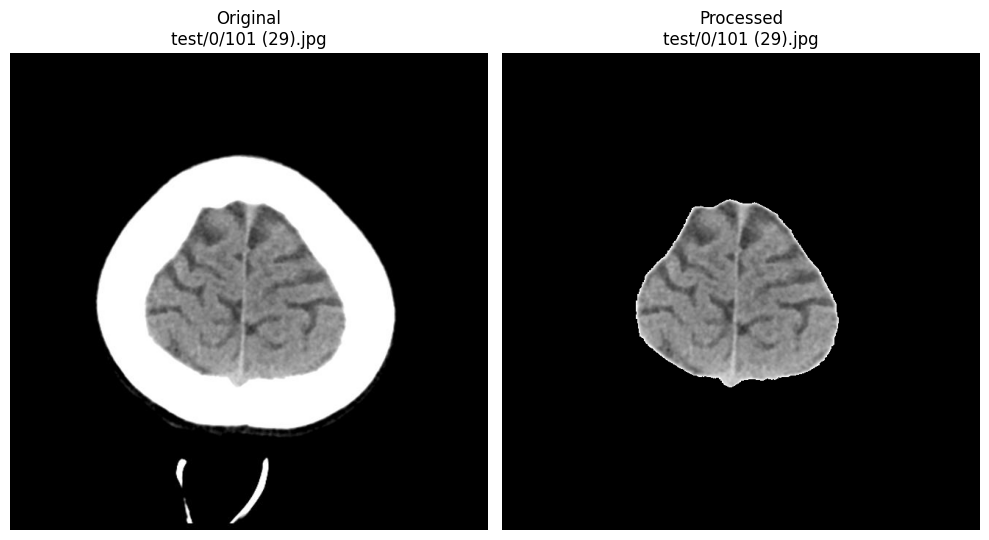

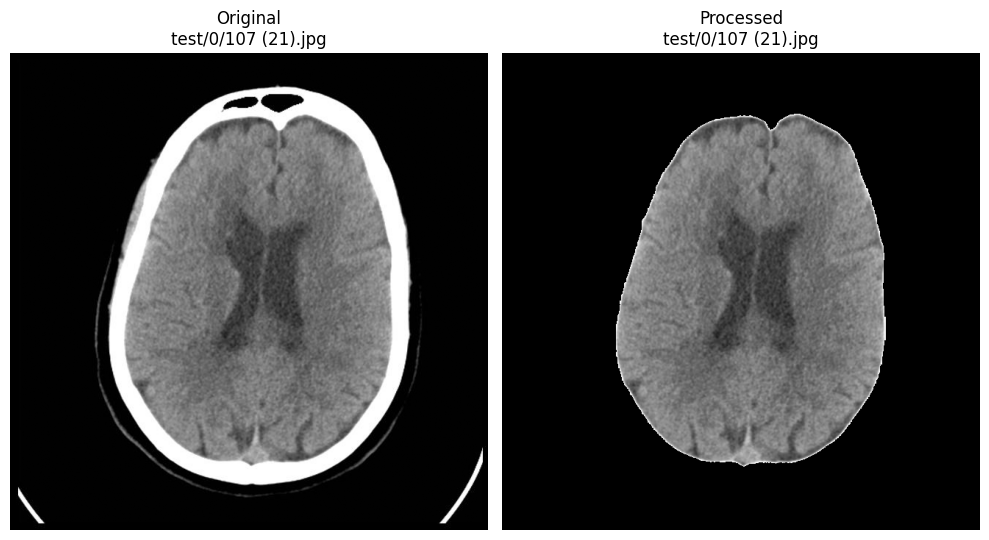

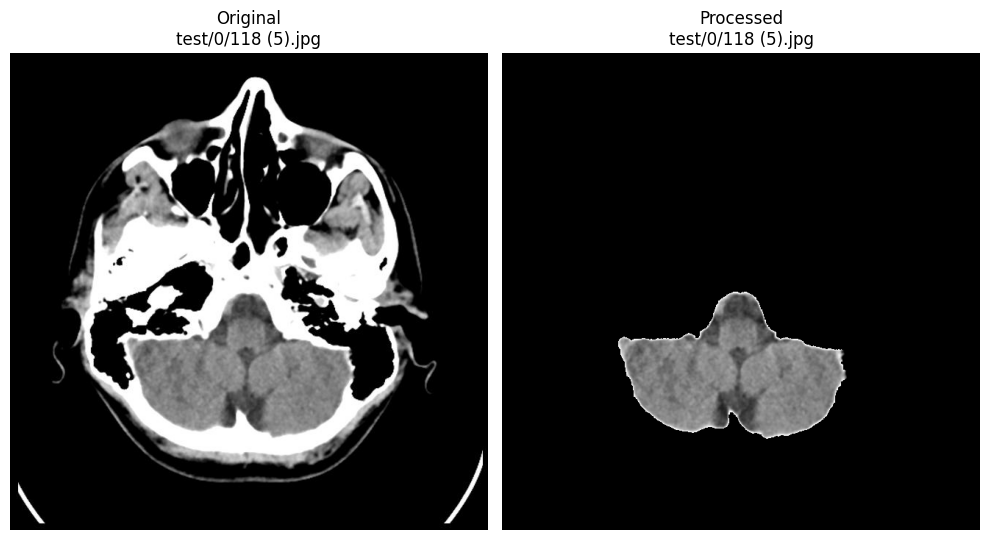

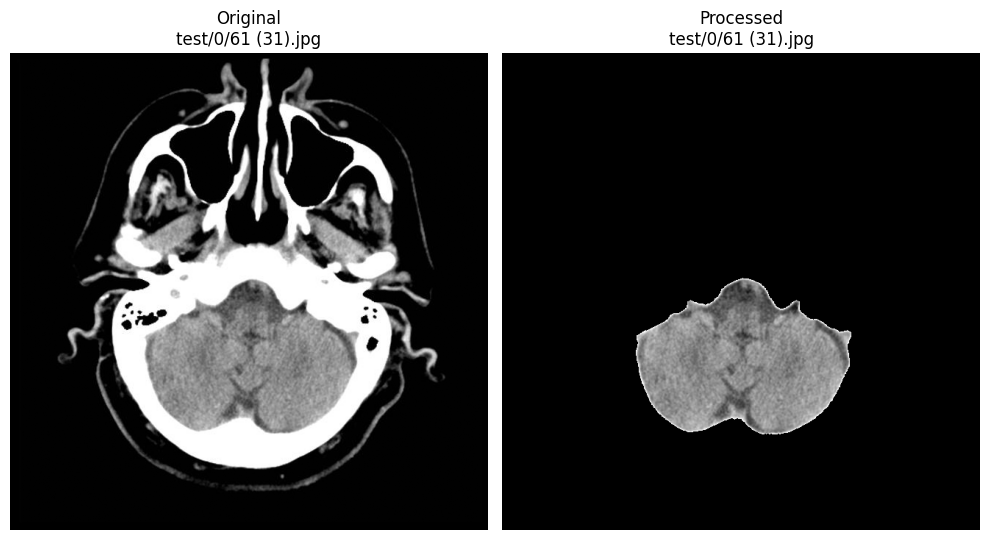

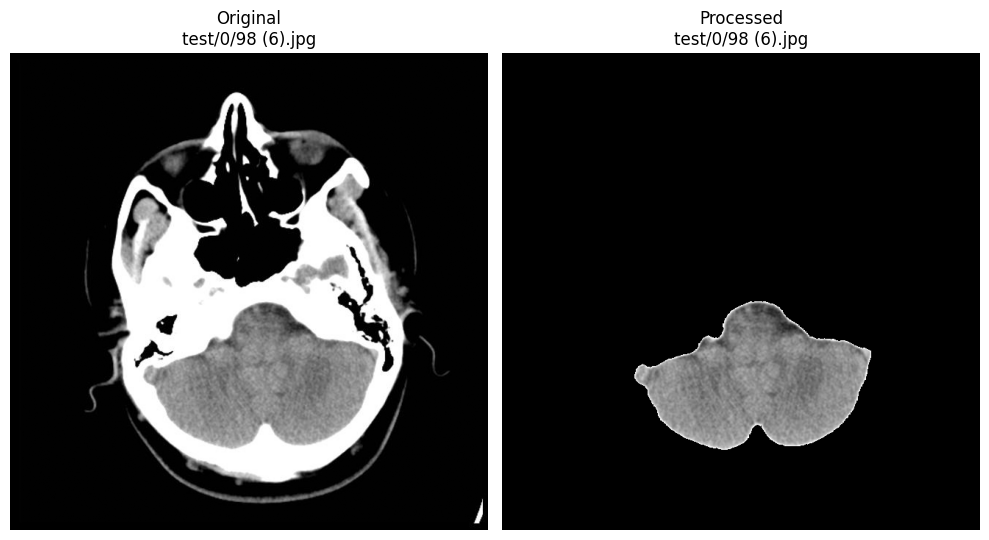

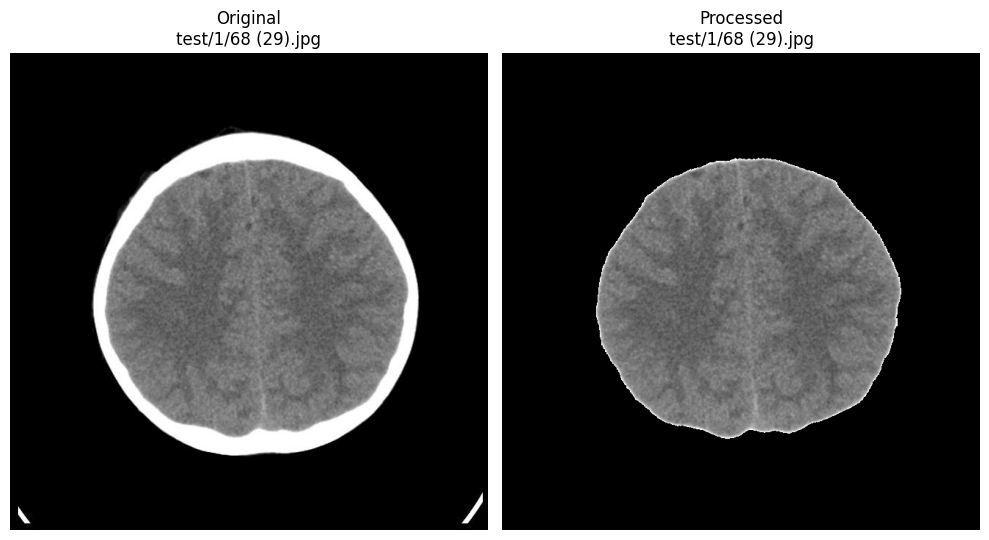

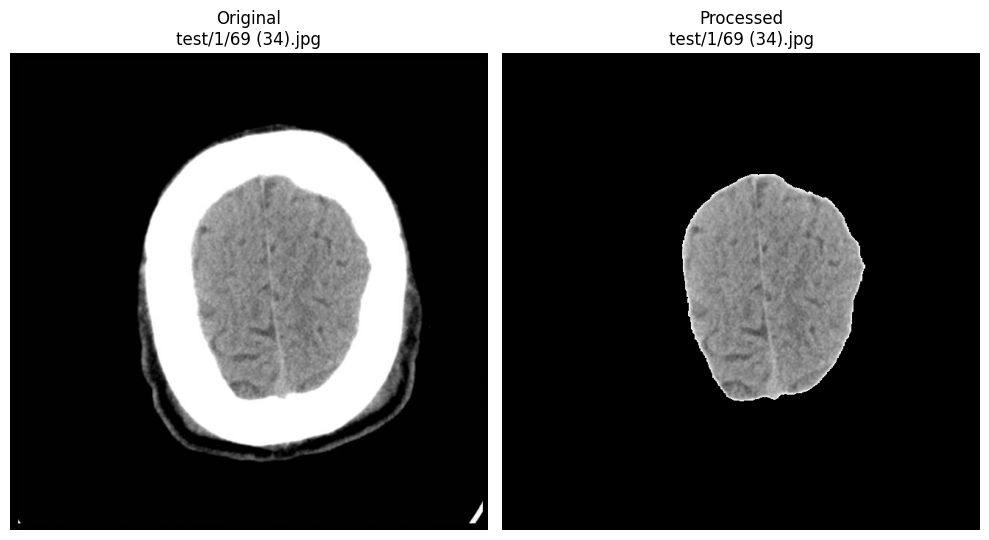

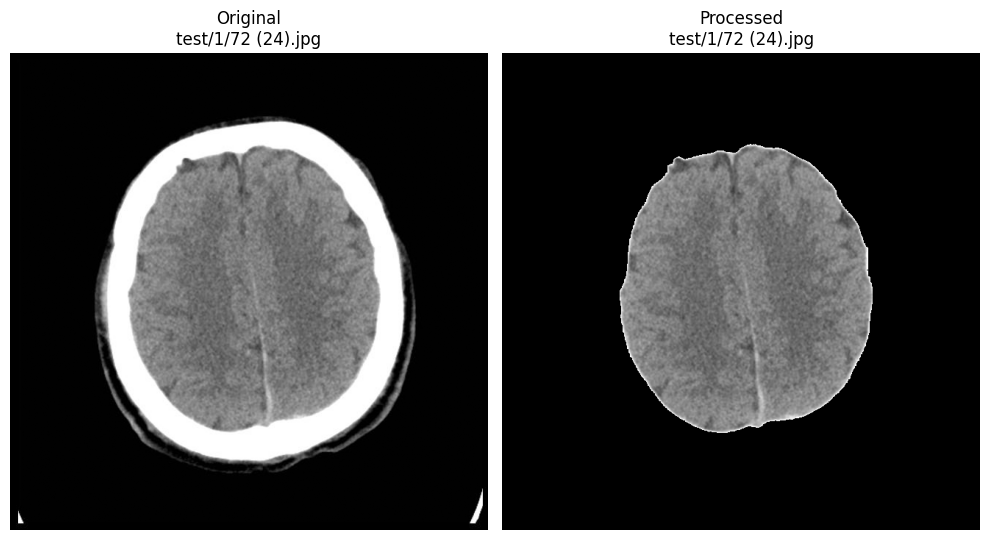

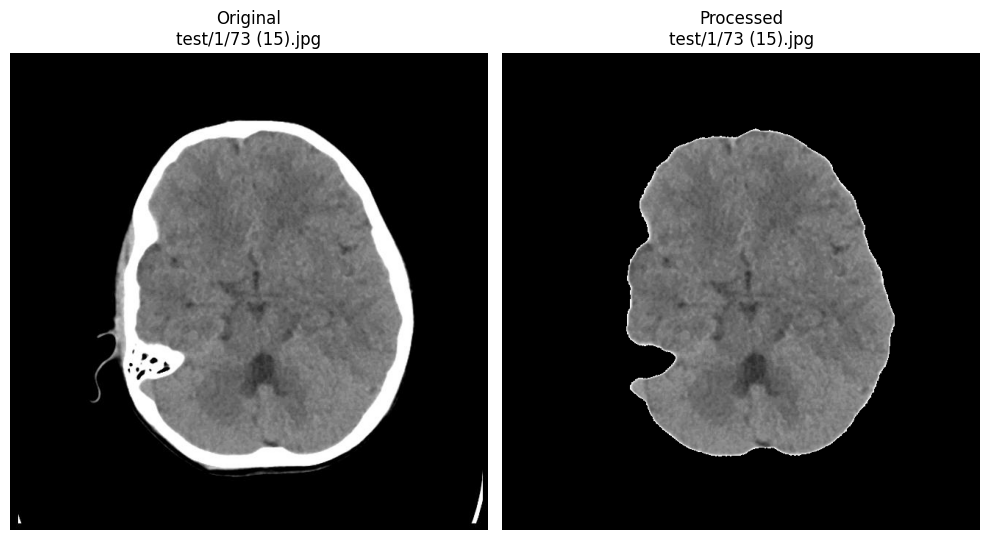

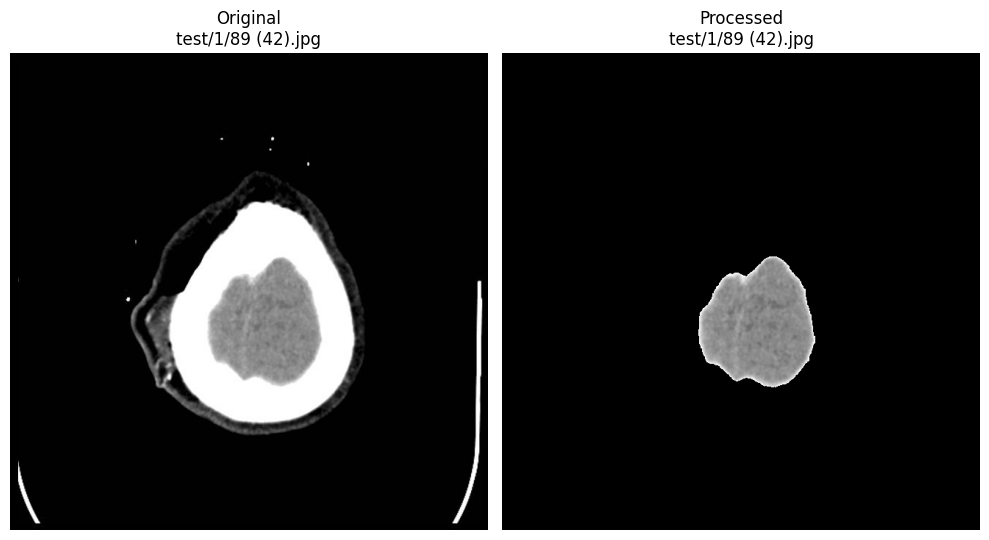

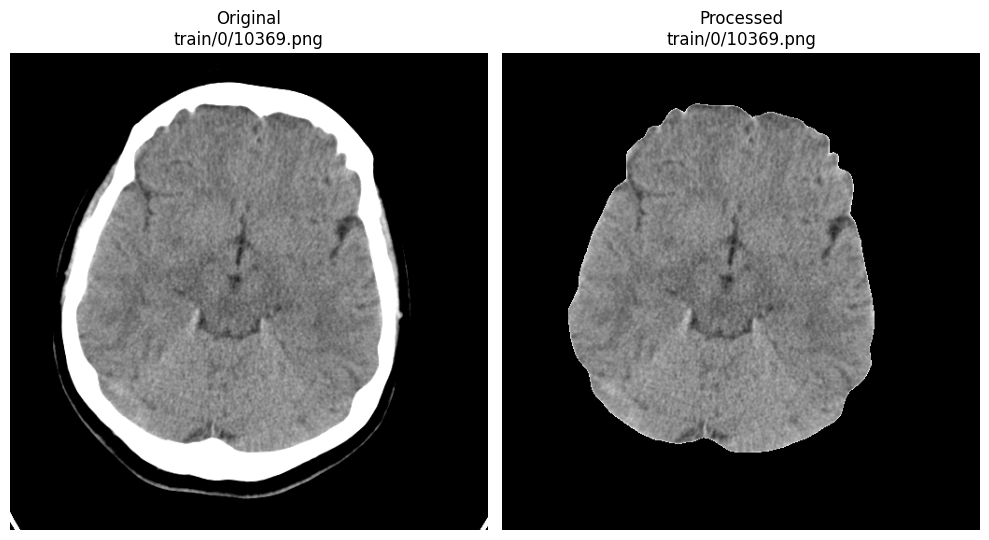

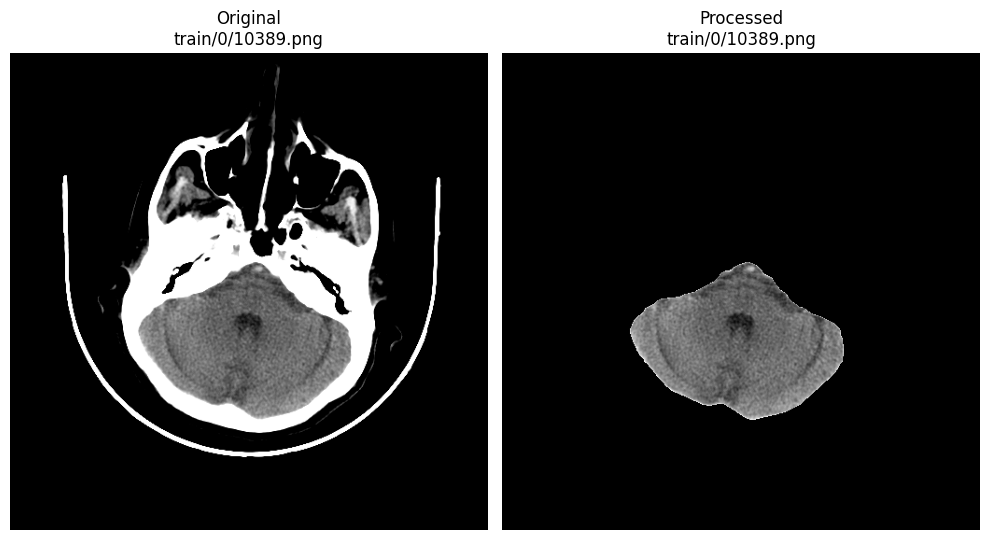

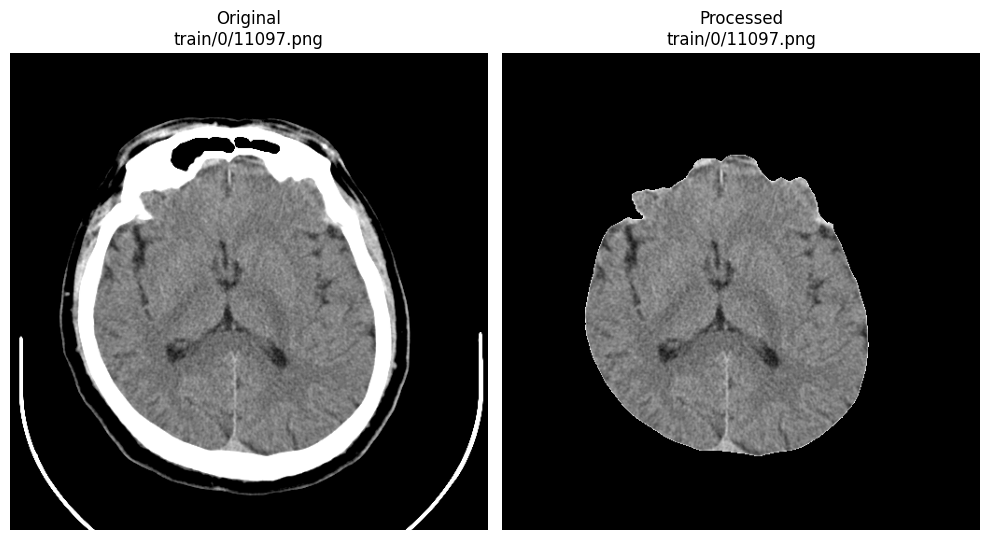

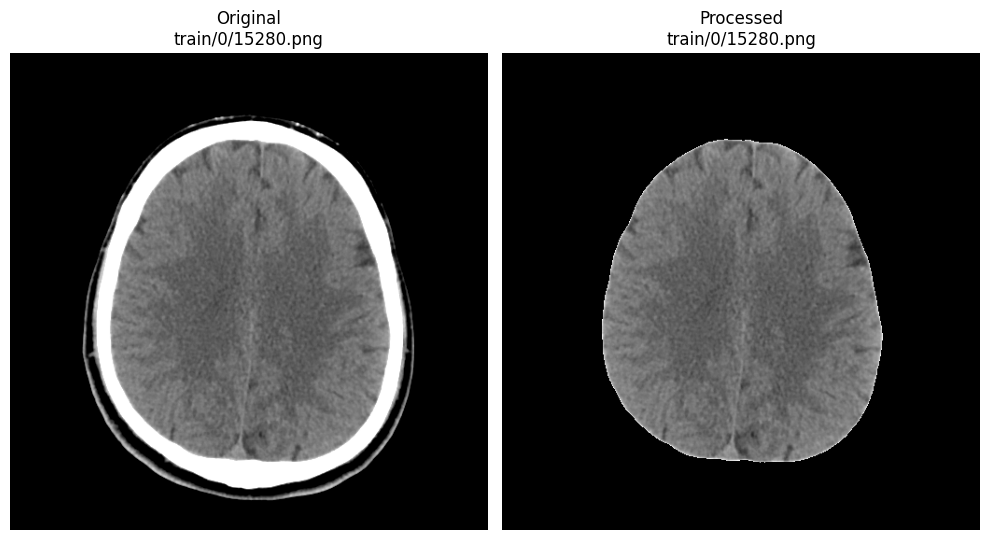

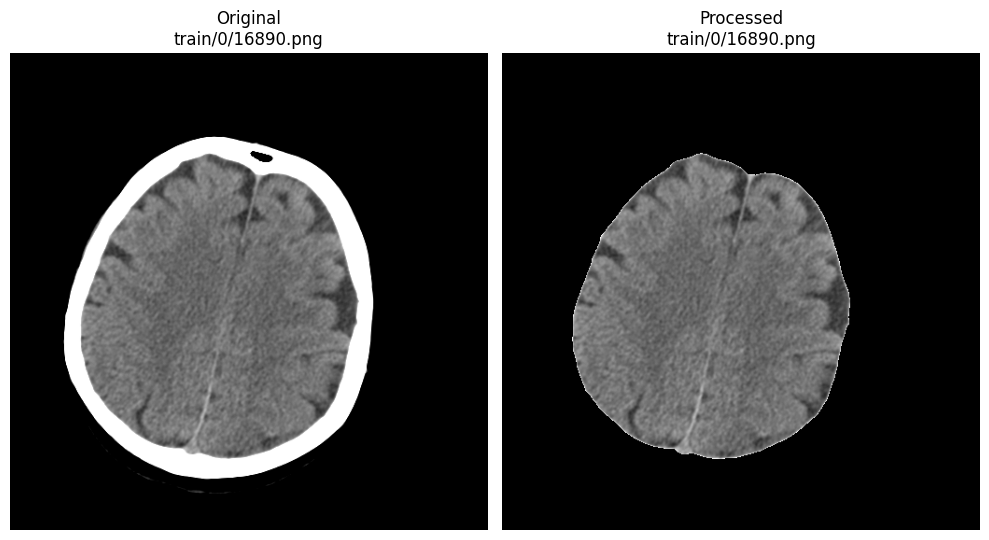

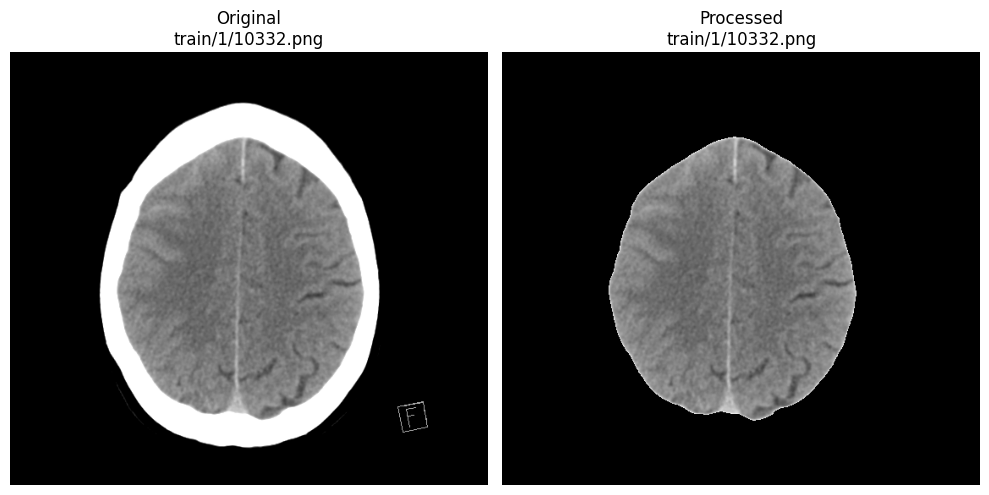

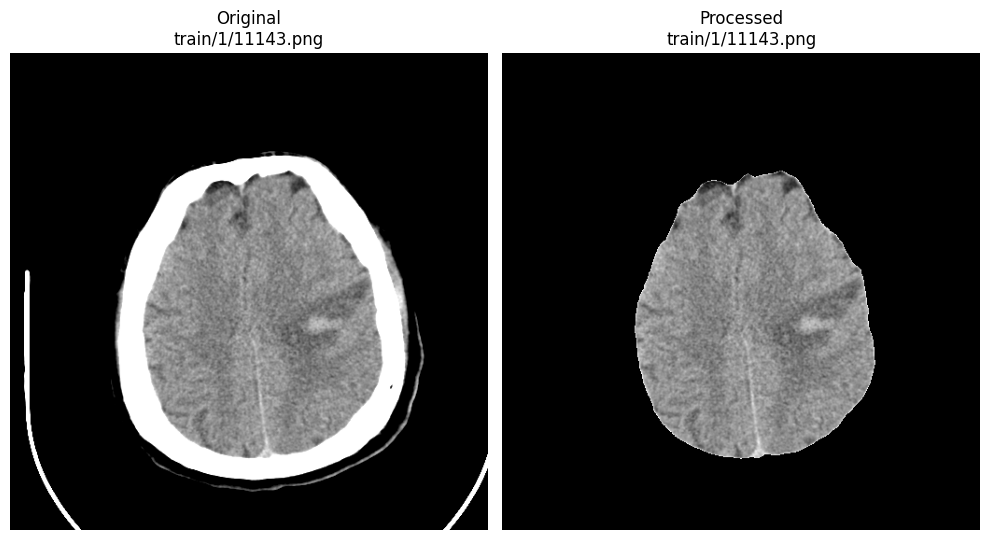

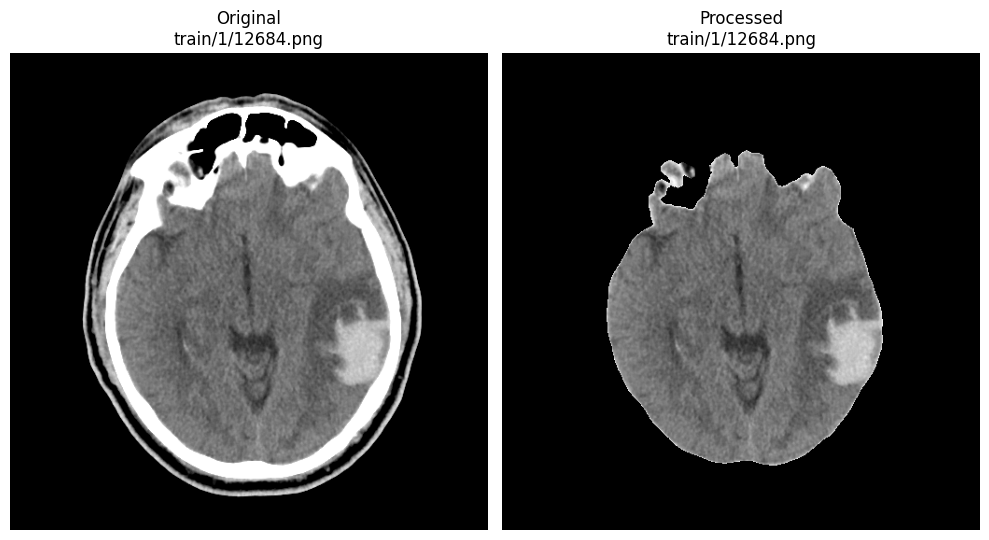

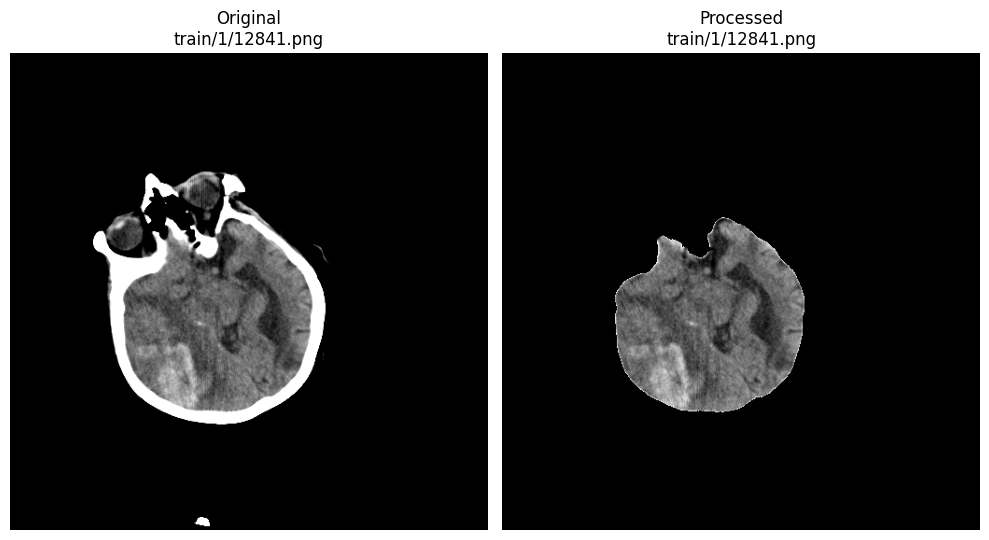

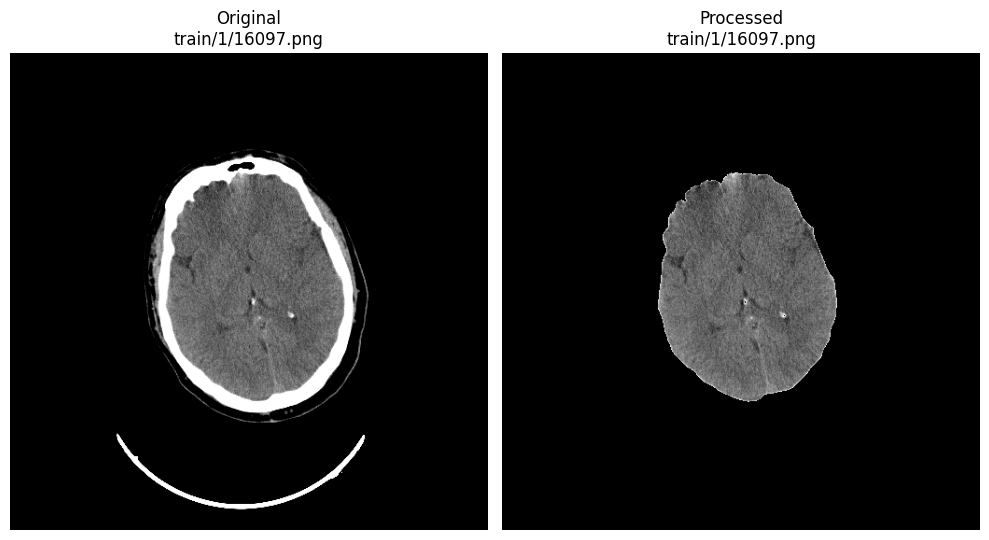

✅ Tüm işlemler başarıyla tamamlandı!
Sonuçlar 'c:\Users\Ersin\Desktop\Biyomed\Quiz5\result' klasörüne kaydedildi.


In [7]:
run_pipeline()

# 6. Klasör Analiz Fonksiyonu

In [8]:
def analyze_image_counts():
    BASE_DIR = os.getcwd()
    RESULT_DIR = os.path.join(BASE_DIR, 'result')
    
    if not os.path.exists(RESULT_DIR):
        print("HATA: 'result' klasörü bulunamadı! Önce işlemleri çalıştırın.")
        return
    
    print("\n" + "="*50)
    print("RESİM SAYIM RAPORU")
    print("="*50)
    
    total_images = 0
    
    for dataset in ['train', 'test']:
        dataset_path = os.path.join(RESULT_DIR, dataset)
        if not os.path.exists(dataset_path):
            print(f"\n⚠️ Uyarı: {dataset} klasörü bulunamadı!")
            continue
            
        print(f"\n📂 {dataset.upper()} KLASÖRÜ")
        print("-"*40)
        
        class0_path = os.path.join(dataset_path, '0')
        class1_path = os.path.join(dataset_path, '1')
        
        # Class 0 sayımı
        class0_count = 0
        if os.path.exists(class0_path):
            class0_count = len([f for f in os.listdir(class0_path) 
                             if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
        
        # Class 1 sayımı
        class1_count = 0
        if os.path.exists(class1_path):
            class1_count = len([f for f in os.listdir(class1_path) 
                             if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
        
        # Dataset toplamı
        dataset_total = class0_count + class1_count
        total_images += dataset_total
        
        # Rapor çıktısı
        print(f"┣ 0/ klasörü: {class0_count} resim")
        print(f"┣ 1/ klasörü: {class1_count} resim")
        print(f"┗ TOPLAM ({dataset}): {dataset_total} resim")
    
    print("\n" + "="*50)
    print(f"📊 GENEL TOPLAM: {total_images} resim")
    print("="*50)

# %% [markdown]
# # 7. Analiz Fonksiyonunu Çalıştır
# %%
analyze_image_counts()


RESİM SAYIM RAPORU

📂 TRAIN KLASÖRÜ
----------------------------------------
┣ 0/ klasörü: 4564 resim
┣ 1/ klasörü: 2383 resim
┗ TOPLAM (train): 6947 resim

📂 TEST KLASÖRÜ
----------------------------------------
┣ 0/ klasörü: 1551 resim
┣ 1/ klasörü: 950 resim
┗ TOPLAM (test): 2501 resim

📊 GENEL TOPLAM: 9448 resim


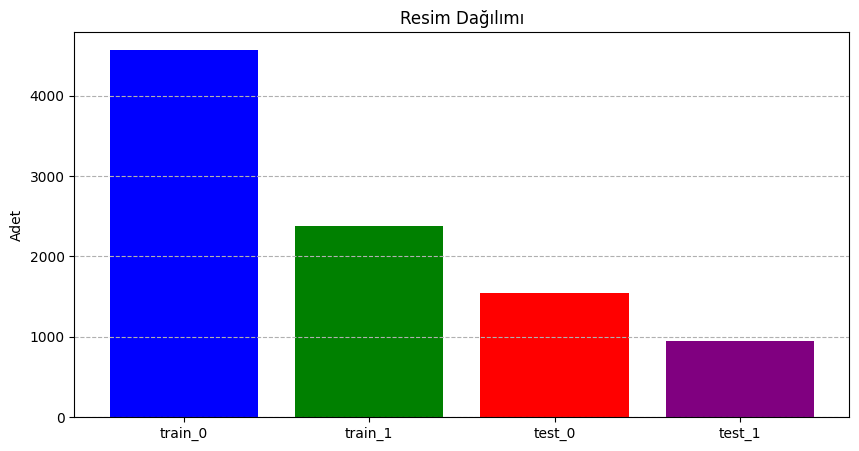

In [9]:
def visualize_counts():
    import matplotlib.pyplot as plt
    
    counts = {'train_0': 0, 'train_1': 0, 'test_0': 0, 'test_1': 0}
    
    for dataset in ['train', 'test']:
        for class_label in ['0', '1']:
            path = os.path.join('result', dataset, class_label)
            if os.path.exists(path):
                counts[f"{dataset}_{class_label}"] = len(
                    [f for f in os.listdir(path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
                )
    
    plt.figure(figsize=(10, 5))
    plt.bar(counts.keys(), counts.values(), color=['blue', 'green', 'red', 'purple'])
    plt.title('Resim Dağılımı')
    plt.ylabel('Adet')
    plt.grid(axis='y', linestyle='--')
    plt.show()

visualize_counts()